In [1]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
import keras


In [ ]:
import numpy as np
import cv2
from sklearn.model_selection import train_test_split
from PIL import Image
import os
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.applications import MobileNet
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_curve, roc_auc_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import roc_curve, auc, precision_recall_curve
from sklearn.calibration import calibration_curve
import keras


In [2]:
defected_path = '/Users/ketankinniwadi/Desktop/industrial equipment classification/Industrial-Equipment/Defected'
non_defected_path = '/Users/ketankinniwadi/Desktop/industrial equipment classification/Industrial-Equipment/Non-Defected'

In [3]:
def load_and_resize_images(folder_path, label, target_size=(100, 100), grayscale=True):
    images = []
    labels = []
    for filename in os.listdir(folder_path):
        if filename.endswith('.jpg') or filename.endswith(".png") or filename.endswith(".jpeg"):
            try:
                # Open the image file
                image = Image.open(os.path.join(folder_path, filename))
                # Resize the image to the target size
                image_resized = image.resize(target_size)
                # Convert the image to grayscale if specified
                if grayscale:
                    image_resized = image_resized.convert('L')
                # Convert the image to a numpy array
                image_array = np.array(image_resized)
                # Add the image and label to the lists
                images.append(image_array)
                labels.append(label)
            except Exception as e:
                print(f"Error processing {filename}: {str(e)}")
    return images, labels

In [4]:
# Load and resize images from Defected folder
defected_images, defected_labels = load_and_resize_images(defected_path, label=0)

# Load and resize images from Non-Defected folder
non_defected_images, non_defected_labels = load_and_resize_images(non_defected_path, label=1)

# Check the number of images in each category
print("Number of defected images:", len(defected_images))
print("Number of non-defected images:", len(non_defected_images))

Number of defected images: 2574
Number of non-defected images: 1827


In [5]:
# Concatenate defected and non-defected images and labels
image_data = np.concatenate((defected_images, non_defected_images), axis=0)
label_data = np.concatenate((defected_labels, non_defected_labels), axis=0)

In [6]:
#Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(image_data, label_data, test_size=0.2, random_state=42)


In [7]:
#Normalization
X_train = X_train / 255.0
X_test = X_test / 255.0

In [8]:
#Hypertuning
import kerastuner as kt

def create_model(hp):
    model = models.Sequential()
    model.add(layers.Conv2D(hp.Int('conv1_units', min_value=32, max_value=128, step=32),
                             (3, 3),
                             activation='relu',
                             input_shape=(100,100,1)))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(hp.Int('conv2_units', min_value=32, max_value=128, step=32),
                             (3, 3),
                             activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Flatten())
    model.add(Dense(hp.Int('dense_units', min_value=32, max_value=128, step=32),
                    activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    
    model.compile(optimizer='adam',
                  loss='binary_crossentropy',
                  metrics=['accuracy'])
    
    return model

tuner = kt.Hyperband(create_model,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='my_dir',
                     project_name='intro_to_kt')

early_stopping = keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search_space_summary()


tuner.search(X_train, y_train,
             epochs=10,
             validation_data=(X_test, y_test),
             callbacks=[early_stopping])

best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

model = tuner.hypermodel.build(best_hps)


Trial 30 Complete [00h 02m 42s]
val_accuracy: 0.8501702547073364

Best val_accuracy So Far: 0.8615210056304932
Total elapsed time: 00h 33m 04s


In [9]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 98, 98, 64)        640       
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 49, 49, 64)        0         
 g2D)                                                            
                                                                 
 conv2d_3 (Conv2D)           (None, 47, 47, 64)        36928     
                                                                 
 max_pooling2d_3 (MaxPoolin  (None, 23, 23, 64)        0         
 g2D)                                                            
                                                                 
 flatten_1 (Flatten)         (None, 33856)             0         
                                                                 
 dense_2 (Dense)             (None, 96)               

In [10]:
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_test, y_test))

# Evaluate the model on the test data
test_loss, test_accuracy = model.evaluate(X_test, y_test)

print("Test Loss:", test_loss)
print("Test Accuracy:", test_accuracy)


Epoch 1/10
110/110 [==============================] - 12s 108ms/step - loss: 0.5197 - accuracy: 0.7219 - val_loss: 0.4686 - val_accuracy: 0.7753
Epoch 2/10
110/110 [==============================] - 13s 115ms/step - loss: 0.3627 - accuracy: 0.8216 - val_loss: 0.3576 - val_accuracy: 0.8297
Epoch 3/10
110/110 [==============================] - 12s 109ms/step - loss: 0.3305 - accuracy: 0.8415 - val_loss: 0.3582 - val_accuracy: 0.8218
Epoch 4/10
110/110 [==============================] - 12s 105ms/step - loss: 0.2646 - accuracy: 0.8727 - val_loss: 0.3565 - val_accuracy: 0.8411
Epoch 5/10
110/110 [==============================] - 12s 107ms/step - loss: 0.2087 - accuracy: 0.9023 - val_loss: 0.3617 - val_accuracy: 0.8343
Epoch 6/10
110/110 [==============================] - 11s 104ms/step - loss: 0.1954 - accuracy: 0.9097 - val_loss: 0.3989 - val_accuracy: 0.8263
Epoch 7/10
110/110 [==============================] - 12s 105ms/step - loss: 0.1484 - accuracy: 0.9338 - val_loss: 0.4096 - val_ac

In [11]:
# Set Seaborn style
sns.set(style="whitegrid")


# Get the training history
train_loss = history.history['loss']
val_loss = history.history['val_loss']
train_accuracy = history.history['accuracy']
val_accuracy = history.history['val_accuracy']
epochs = range(1, len(train_loss) + 1)

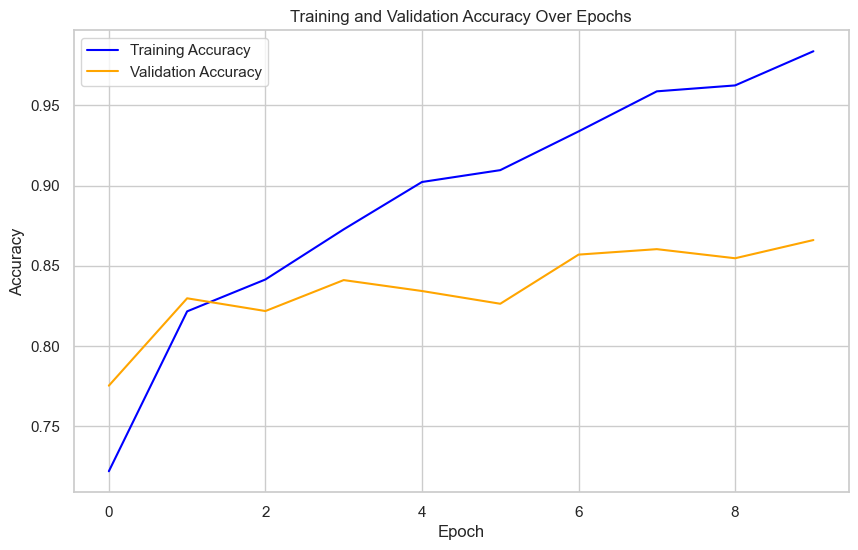

In [12]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.plot(history.history['accuracy'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Accuracy Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

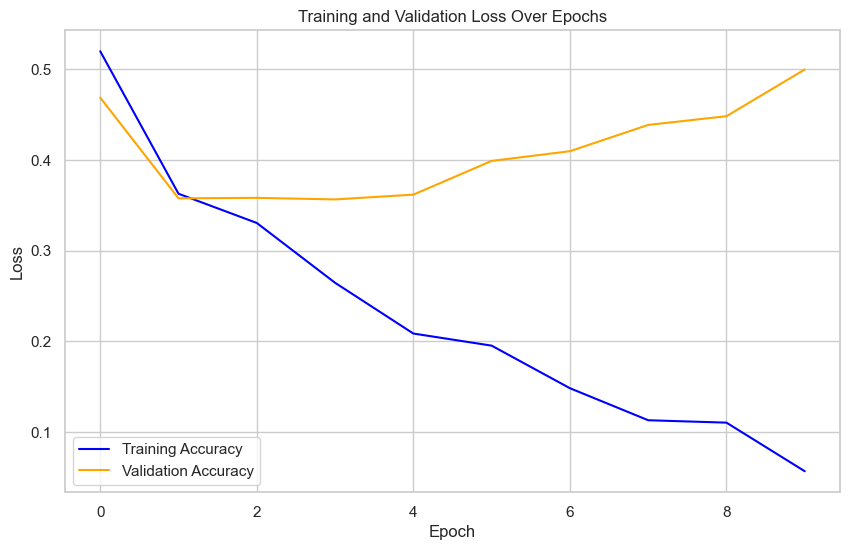

In [13]:
# Plot training and validation accuracy
plt.figure(figsize=(10, 6))
sns.set(style="whitegrid")
plt.plot(history.history['loss'], label='Training Accuracy', color='blue')
plt.plot(history.history['val_loss'], label='Validation Accuracy', color='orange')
plt.title('Training and Validation Loss Over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [15]:
# Evaluate the model on the validation data
evaluation = model.evaluate(X_test, y_test)

# Print the evaluation results
print("Evaluation Loss:", evaluation[0])
print("Evaluation Accuracy:", evaluation[1])


28/28 [==============================] - 1s 31ms/step - loss: 0.4997 - accuracy: 0.8661
Evaluation Loss: 0.49966320395469666
Evaluation Accuracy: 0.866061270236969


In [16]:
predictions = model.predict(X_test)

for i in range(min(5, len(X_test))):
    print("Predicted class probabilities for image", i+1, ":", predictions[i])


28/28 [==============================] - 1s 28ms/step
Predicted class probabilities for image 1 : [0.00883093]
Predicted class probabilities for image 2 : [0.830016]
Predicted class probabilities for image 3 : [0.99951786]
Predicted class probabilities for image 4 : [1.4727221e-21]
Predicted class probabilities for image 5 : [1.3767633e-10]


In [17]:
predicted_labels = (predictions > 0.5).astype("int32")

for i in range(min(5, len(X_test))):
    print("Predicted label for image", i+1, ":", predicted_labels[i])

Predicted label for image 1 : [0]
Predicted label for image 2 : [1]
Predicted label for image 3 : [1]
Predicted label for image 4 : [0]
Predicted label for image 5 : [0]


In [21]:
class_mapping = {0: "Defected", 1: "Non-Defected"}
predictions = model.predict(X_test)
predicted_labels = (predictions > 0.5).astype("int32")

actual_labels = [class_mapping[label] for label in y_test]
   
additional_data = {
    "Actual Class Name": actual_labels,
    "Predicted Class Name": [class_mapping[label] for label in predicted_labels.flatten()]
}

data = {
    "Predicted Probabilities": predictions.flatten(),  
    "Actual Labels": y_test,
    "Predicted Labels": predicted_labels.flatten(),
    **additional_data  
}
    
df = pd.DataFrame(data)

28/28 [==============================] - 1s 28ms/step


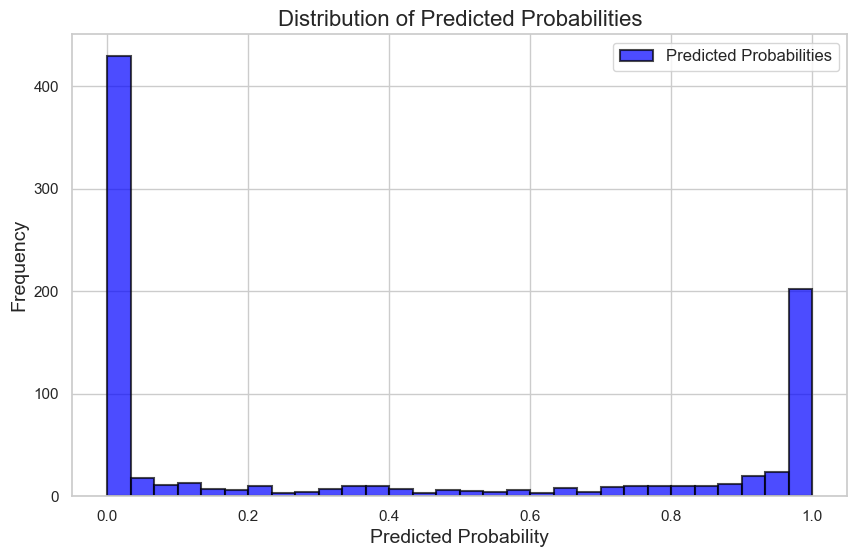

In [22]:
def plot_predicted_probabilities(predicted_probabilities):
    plt.figure(figsize=(10, 6))
    plt.hist(predicted_probabilities, bins=30, alpha=0.7, color='blue', edgecolor='black', linewidth=1.5, label='Predicted Probabilities')
    plt.xlabel('Predicted Probability', fontsize=14)
    plt.ylabel('Frequency', fontsize=14)
    plt.title('Distribution of Predicted Probabilities', fontsize=16)
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show()

plot_predicted_probabilities(predictions)

In [23]:
styled_df = df.sample(30).style.set_properties(**{'text-align': 'center'}) \
                             .set_caption("Predictions and Actual Labels") \
                             .format({"Predicted Probabilities": "{:.4f}"}) \
                             .background_gradient(cmap='viridis', subset=["Predicted Probabilities"])
styled_df

,Predicted Probabilities,Actual Labels,Predicted Labels,Actual Class Name,Predicted Class Name
192,0.7890,1,1,Non-Defected,Non-Defected
527,0.4710,1,0,Non-Defected,Defected
251,0.5507,0,1,Defected,Non-Defected
109,0.0000,0,0,Defected,Defected
796,0.0039,0,0,Defected,Defected
245,0.0118,0,0,Defected,Defected
831,0.7096,0,1,Defected,Non-Defected
714,0.0000,0,0,Defected,Defected
369,0.9798,1,1,Non-Defected,Non-Defected
45,0.9805,1,1,Non-Defected,Non-Defected


Accuracy: 0.8660612939841089
Precision: 0.8397626112759644
Recall: 0.8155619596541787
F1-score: 0.8274853801169592
ROC AUC score: 0.8572191820742803
Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.90      0.89       534
           1       0.84      0.82      0.83       347

    accuracy                           0.87       881
   macro avg       0.86      0.86      0.86       881
weighted avg       0.87      0.87      0.87       881

Confusion Matrix:


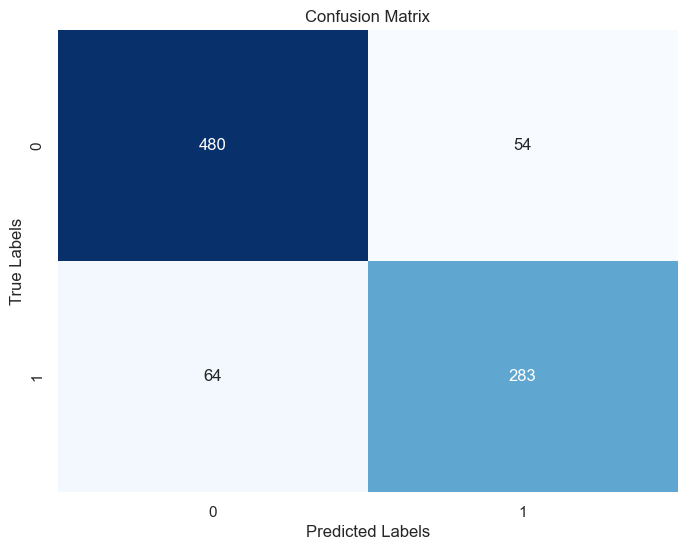

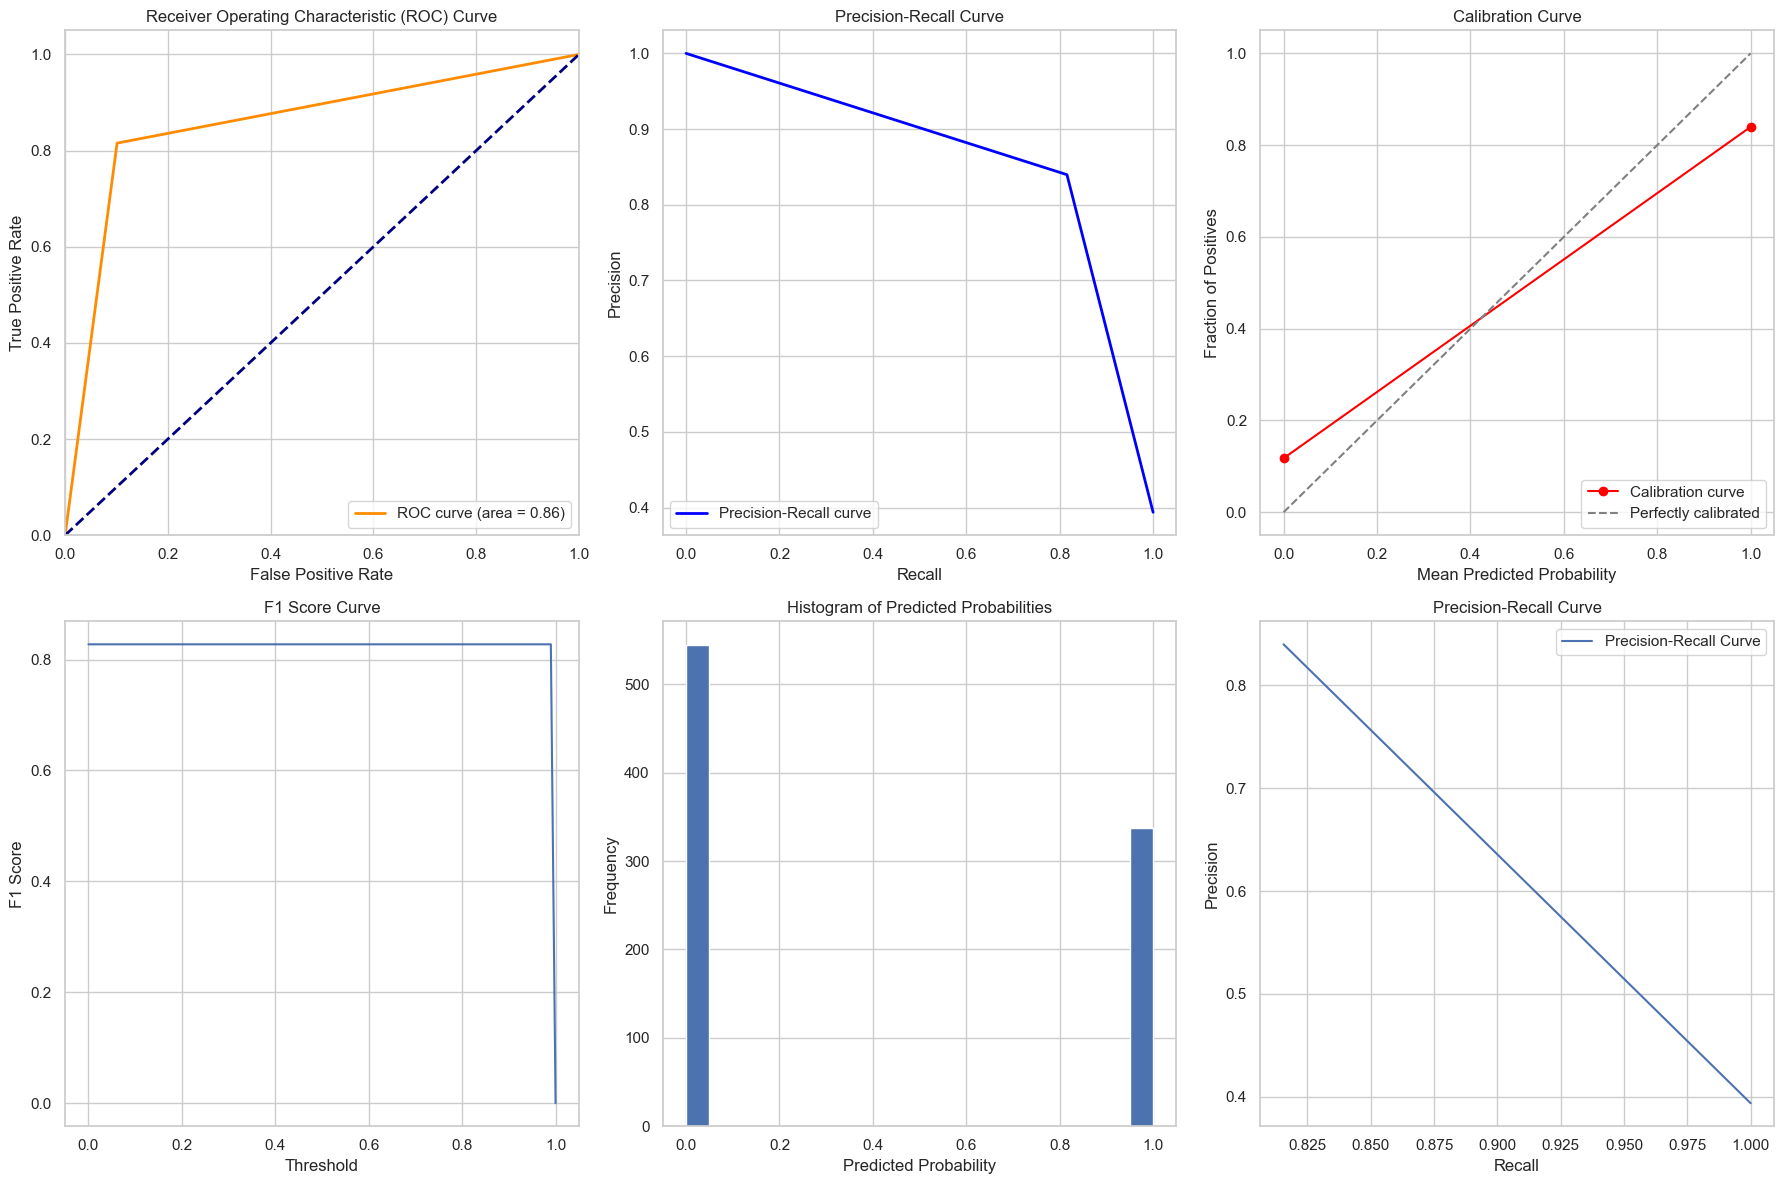

In [24]:
print("==================================================================================")
# Compute accuracy
accuracy = accuracy_score(y_test, predicted_labels)
print("Accuracy:", accuracy)
print("==================================================================================")
# Compute precision
precision = precision_score(y_test, predicted_labels)
print("Precision:", precision)
print("==================================================================================")
# Compute recall
recall = recall_score(y_test, predicted_labels)
print("Recall:", recall)
print("==================================================================================")
# Compute F1-score
f1 = f1_score(y_test, predicted_labels)
print("F1-score:", f1)
print("==================================================================================")
# Compute ROC AUC score
roc_auc = roc_auc_score(y_test, predicted_labels)
print("ROC AUC score:", roc_auc)
# Generate classification report
print("==================================================================================")
print("Classification Report:")
print(classification_report(y_test, predicted_labels))
print("==================================================================================")
# Generate confusion matrix
print("Confusion Matrix:")
conf_matrix = confusion_matrix(y_test, predicted_labels)
# Plot the heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.title("Confusion Matrix")
plt.show()
print("==================================================================================")
# Set up subplots with 2 rows and 3 columns
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Compute ROC curve
fpr, tpr, _ = roc_curve(y_test, predicted_labels)
roc_auc = auc(fpr, tpr)

# Plot ROC curve
axes[0, 0].plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
axes[0, 0].plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
axes[0, 0].set_xlim([0.0, 1.0])
axes[0, 0].set_ylim([0.0, 1.05])
axes[0, 0].set_xlabel('False Positive Rate')
axes[0, 0].set_ylabel('True Positive Rate')
axes[0, 0].set_title('Receiver Operating Characteristic (ROC) Curve')
axes[0, 0].legend(loc="lower right")

# Plot precision-recall curve
precision, recall, _ = precision_recall_curve(y_test, predicted_labels)
axes[0, 1].plot(recall, precision, color='blue', lw=2, label='Precision-Recall curve')
axes[0, 1].set_xlabel('Recall')
axes[0, 1].set_ylabel('Precision')
axes[0, 1].set_title('Precision-Recall Curve')
axes[0, 1].legend(loc="lower left")

# Plot calibration curve
prob_true, prob_pred = calibration_curve(y_test, predicted_labels, n_bins=10)
axes[0, 2].plot(prob_pred, prob_true, marker='o', color='red', label='Calibration curve')
axes[0, 2].plot([0, 1], [0, 1], linestyle='--', color='gray', label='Perfectly calibrated')
axes[0, 2].set_xlabel('Mean Predicted Probability')
axes[0, 2].set_ylabel('Fraction of Positives')
axes[0, 2].set_title('Calibration Curve')
axes[0, 2].legend(loc="lower right")

# Plot F1 score curve
thresholds = np.linspace(0, 1, 100)
f1_scores = [f1_score(y_test, (predicted_labels > t).astype(int)) for t in thresholds]
axes[1, 0].plot(thresholds, f1_scores)
axes[1, 0].set_xlabel('Threshold')
axes[1, 0].set_ylabel('F1 Score')
axes[1, 0].set_title('F1 Score Curve')

# Plot histogram of predicted probabilities
axes[1, 1].hist(predicted_labels, bins=20)
axes[1, 1].set_xlabel('Predicted Probability')
axes[1, 1].set_ylabel('Frequency')
axes[1, 1].set_title('Histogram of Predicted Probabilities')

# Show precision-recall curve
axes[1, 2].plot(recall[:-1], precision[:-1], label="Precision-Recall Curve")
axes[1, 2].set_xlabel('Recall')
axes[1, 2].set_ylabel('Precision')
axes[1, 2].set_title('Precision-Recall Curve')
axes[1, 2].legend()

# Adjust layout
plt.tight_layout()
plt.show()